In [ ]:
#pip install openmeteo-requests
#pip install requests-cache retry-requests numpy pandas


In [80]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 50.85,
	"longitude": 4.35,
	"minutely_15": [
			"temperature_2m",           # 1. Temperature
			"wind_speed_10m",           # 2. Wind Speed
			"shortwave_radiation",      # 3. Solar Irradiance (GHI)
			"cloud_cover",              # 4. Cloud Cover
			"precipitation",            # 5. Precipitation
			"relative_humidity_2m",     # 6. Humidity
			"surface_pressure"          # 7. Surface Pressure
		],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
minutely_15 = response.Minutely15()
temperature_2m = minutely_15.Variables(0).ValuesAsNumpy()
wind_speed_10m = minutely_15.Variables(1).ValuesAsNumpy()
shortwave_radiation = minutely_15.Variables(2).ValuesAsNumpy()
cloud_cover = minutely_15.Variables(3).ValuesAsNumpy()
precipitation = minutely_15.Variables(4).ValuesAsNumpy()
relative_humidity_2m = minutely_15.Variables(4).ValuesAsNumpy()
surface_pressure = minutely_15.Variables(4).ValuesAsNumpy()



minutely_15_data = {"date": pd.date_range(
	start = pd.to_datetime(minutely_15.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(minutely_15.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = minutely_15.Interval()),
	inclusive = "left"
)}

minutely_15_data["temperature_2m"] = temperature_2m
minutely_15_data["wind_speed_10m"] = wind_speed_10m
minutely_15_data["shortwave_radiation"] = shortwave_radiation
minutely_15_data["cloud_cover"] = cloud_cover
minutely_15_data["precipitation"] = precipitation
minutely_15_data["relative_humidity_2m"] = relative_humidity_2m
minutely_15_data["surface_pressure"] = surface_pressure

minutely_15_dataframe = pd.DataFrame(data = minutely_15_data)
print("\nMinutely 15 data\n", minutely_15_dataframe)


Coordinates: 50.854000091552734°N 4.349999904632568°E
Elevation: 27.0 m asl
Timezone difference to GMT+0: 0s

Minutely 15 data
                          date  temperature_2m  wind_speed_10m  \
0   2025-10-29 00:00:00+00:00           11.70       17.639999   
1   2025-10-29 00:15:00+00:00           11.60       17.639999   
2   2025-10-29 00:30:00+00:00           11.45       17.639999   
3   2025-10-29 00:45:00+00:00           11.30       17.280001   
4   2025-10-29 01:00:00+00:00           11.25       17.280001   
..                        ...             ...             ...   
283 2025-10-31 22:45:00+00:00           14.05       18.359999   
284 2025-10-31 23:00:00+00:00           14.05       18.359999   
285 2025-10-31 23:15:00+00:00           14.05       18.359999   
286 2025-10-31 23:30:00+00:00           14.05       18.359999   
287 2025-10-31 23:45:00+00:00           14.05       18.359999   

     shortwave_radiation  cloud_cover  precipitation  relative_humidity_2m  \
0            

In [81]:
minutely_15_dataframe.to_csv("Minutely_15_weather_data.csv", index = False)

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>]], dtype=object)

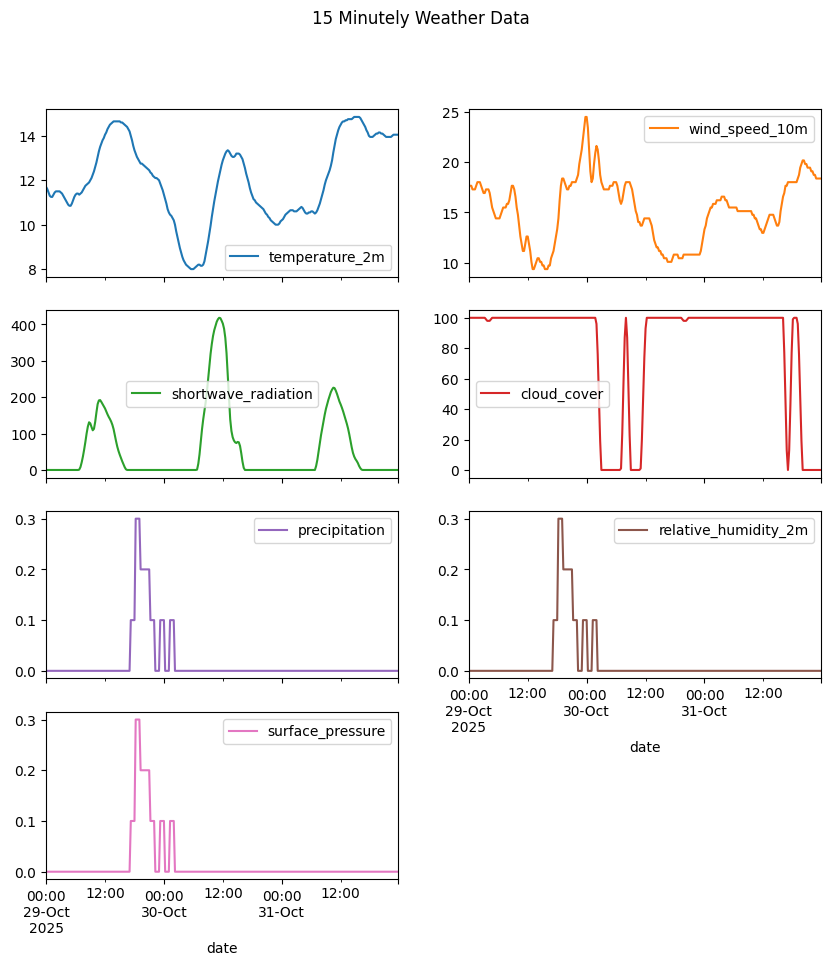

In [82]:
minutely_15_dataframe.plot(x='date', y=['temperature_2m', 'wind_speed_10m', 'shortwave_radiation', 'cloud_cover', 'precipitation', 'relative_humidity_2m', 'surface_pressure'], subplots=True, layout=(4,2), figsize=(10,10), title='15 Minutely Weather Data')